In [1]:
import kaggle


class FrameInfo:
    def __init__(self, frame_number, time_in_milliseconds, measCount, measLowIndex, HighIndex):
        self.frame_number = frame_number
        self.time_in_milliseconds = time_in_milliseconds
        self.measCount=measCount
        self.measLowIndex=measLowIndex
        self.HighIndex=HighIndex
    
    def __repr__(self):
        return f"Frame {self.frame_number} at {self.time_in_milliseconds} ms with {self.measCount} measurements at index {self.measLowIndex} to {self.HighIndex}"
    
    def getNbMeas(self):
        return self.measCount
    def getMeasIndex(self):
        return (self.measLowIndex, self.HighIndex)

In [2]:
#Load the pickle file containing the list of FrameInfo objects
import pickle

# Load the list of frames and there respectives infos from the file
with open('F:/Data_BachelorHES/Video_CNC/frameData.pkl', 'rb') as f:
    frameData = pickle.load(f)
del f

In [2]:
import pandas as pd
import pyarrow as pa 
import pyarrow.parquet as pq

DfLabelledTimeSeries=pd.read_parquet('F:/Data_BachelorHES/DataSet_CNC/CNC_Labelled_Data_Corrected.parquet', engine='pyarrow')


## Export of a selection of frames for relabelling

In [29]:
import os
import shutil
dest_folder='F:\Data_BachelorHES\Video_CNC\subImages'
src_root='F:\Data_BachelorHES\Video_CNC\kaggle_Images'
# Assure que le dossier cible existe
os.makedirs(dest_folder, exist_ok=True)

for subdir in os.listdir(src_root):
   intsubdir=int(subdir) 
   subdirPath=os.path.join(src_root, subdir)
   if 116210<=intsubdir<=122980:
       if os.path.isdir(subdirPath):
           for f in os.listdir(subdirPath):
               
               if f=='ocr_image.png':
                   srcImg=os.path.join(subdirPath, f)
                   destImg=os.path.join(dest_folder, f"{subdir}.png")
                   shutil.copy(srcImg, destImg)
           #images = [f for f in os.listdir(subdirPath) if os.path.isfile(os.path.join(subdir_path, f))]
       #print(subdir)
   if intsubdir>122980:
       break

In [33]:
del dest_folder, src_root,  subdir, intsubdir, subdirPath, f,  srcImg, destImg

In [5]:
myLabelsPath='F:/Data_BachelorHES/Video_CNC/subImages/subLabels.csv'
myLabels=pd.read_csv(myLabelsPath, sep=';', header=None)
myLabels.columns=['frame', 'Label_Program_Line', 'Label_Op_Name', 'Label_Tool_Name']
del myLabelsPath

In [17]:
DfLabelledTimeSeries.loc[DfLabelledTimeSeries['frame'].isin(myLabels['frame']), ['Label_Program_Line', 'Label_Op_Name', 'Label_Tool_Name']]=myLabels[['Label_Program_Line', 'Label_Op_Name', 'Label_Tool_Name']].values

In [ ]:
import pyarrow as pa 
import pyarrow.parquet as pq

myResTable=pa.Table.from_pandas(DfLabelledTimeSeries)
pq.write_table(myResTable, 'F:/Data_BachelorHES/DataSet_CNC/CNC_Labelled_Data_Corrected.parquet')
del myResTable

## Analysis of raw labels

In [3]:
myIndices=[]
for index, row in DfLabelledTimeSeries.iterrows():
    progNum=int(row['Label_Program_Line'].split()[0][1:])
    myIndices.append(progNum)
myIndicesPd=pd.Series(myIndices)
del index, row, progNum, myIndices

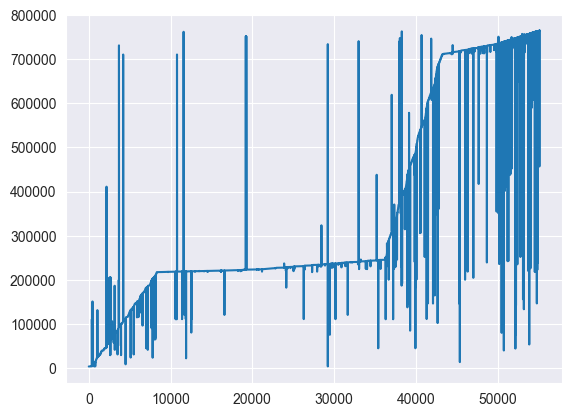

In [65]:
import numpy as np
import matplotlib.pyplot  as plt

x=np.arange(len(myIndicesPd))
plt.plot(x, myIndicesPd)
plt.show()

del myIndices, x




In [79]:
#tentative de smoothing avec une moving average ... pas vraiment ce que je recherche, risque d'accepter des outliers alors qu'ils sont en principe facilement identifiable. Y revenir si autres methodes ne marchenet pas.


winSize=50
size=0
myMovAvIndices=[]
myMovAvIndices.extend(myIndicesPd[0:winSize//2])
for i in range(winSize//2, len(myIndicesPd)-winSize//2):
    windowLst=myIndicesPd[i-winSize//2:i+winSize//2+1].drop(i)
    mean = windowLst.mean()
    std = windowLst.std()
    if myIndicesPd[i] < (mean - 1 * std) or myIndicesPd[i] > (mean + 1 * std):
        size+=1
        myMovAvIndices.append(myMovAvIndices[i-1])
    else:
        myMovAvIndices.append(myIndicesPd[i])
        
myMovAvIndices.extend(myIndicesPd[len(myIndicesPd)-winSize//2:])


In [80]:
del size, winSize, i, windowLst, mean, std

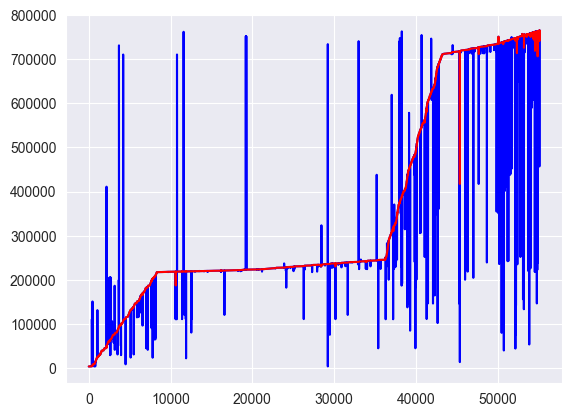

In [81]:
import numpy as np
import matplotlib.pyplot  as plt

x=np.arange(len(myIndicesPd))
plt.plot(x, myIndicesPd, label="Original Values", color='blue')
plt.plot(x, myMovAvIndices, label="Smoothed Values", color='red')
plt.show()

In [74]:
del x

## Cleaned labels with "robust" method
The robust method rely on the median and the median absolute deviation (MAD) to detect outliers. The method is based on the modified Z-score and the threshold is set to 3.
Results show no noticable jumps. The method seems to work well.

In [4]:
from tqdm import tqdm
import numpy as np

def detect_and_remove_local_outliers(data, window_size=10, threshold=3):
    """
    Detect and replace local outliers in a time series with a progress bar.
   
    Args:
        data: List of original time series values.
        window_size: The size of the local segment for detecting outliers.
        threshold: Threshold for detecting outliers (in terms of Z-score).
   
    Returns:
        List of cleaned values with outliers replaced.
    """
    cleaned_data = data.copy()
   
    for i in tqdm(range(len(data)), desc="Processing data"):
        # Define local window boundaries
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
       
        # Extract local window
        localWindow = data[start:end]
       
        # Compute median and MAD (Median Absolute Deviation)
        locMed = np.median(localWindow)
        mad = np.median(np.abs(localWindow - locMed))
        modZScore = 0.6745 * (data[i] - locMed) / (mad if mad > 0 else 1)
       
        # Detect and replace outlier
        if np.abs(modZScore) > threshold:
            cleaned_data[i] = cleaned_data[i-1]  # Replace with previous value
   
    return cleaned_data

# Example usage
myCleanedIndices = detect_and_remove_local_outliers(myIndicesPd, window_size=50, threshold=3)

print("Original Values:", myIndicesPd)
print("Cleaned Values:", myCleanedIndices)

Processing data: 100%|██████████| 55117/55117 [00:15<00:00, 3594.90it/s]

Original Values: 0          3380
1          3380
2          3380
3          3380
4          3380
          ...  
55112    765000
55113    765000
55114    765000
55115    765000
55116    765000
Length: 55117, dtype: int64
Cleaned Values: 0          3380
1          3380
2          3380
3          3380
4          3380
          ...  
55112    765000
55113    765000
55114    765000
55115    765000
55116    765000
Length: 55117, dtype: int64


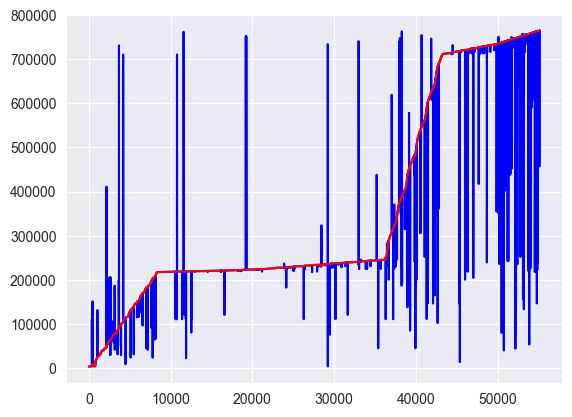

In [5]:
import numpy as np
import matplotlib.pyplot  as plt

x=np.arange(len(myIndicesPd))
plt.plot(x, myIndicesPd, label="Original Values", color='blue')
plt.plot(x, myCleanedIndices, label="Smoothed Values", color='red')
plt.show()

In [15]:
import numpy as np
myDiff=pd.Series()
size=0

for i in range(1,len(myCleanedIndices)):
    if myCleanedIndices[i]<myCleanedIndices[i-1]:
        myDiff[i]=myCleanedIndices[i]-myCleanedIndices[i-1]
        size+=1
    else:
        myDiff[i]=0
        
print(size)

del size, i

149


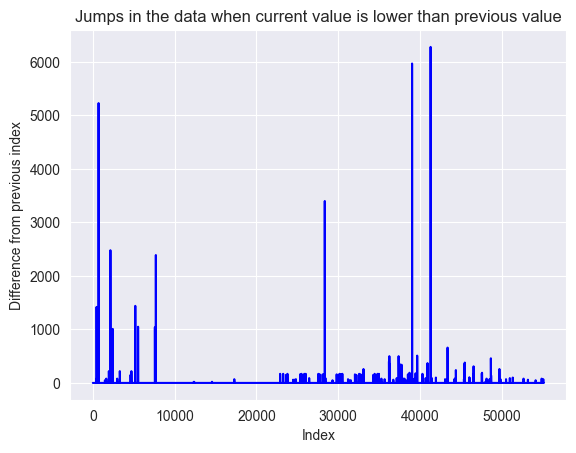

In [16]:
import matplotlib.pyplot  as plt


x=np.arange(len(myDiff))
myDiff=myDiff.abs()
plt.plot(x, myDiff, label="Differences From Previous Indices", color='blue')
plt.title("Jumps in the data when current value is lower than previous value")
plt.xlabel('Index')
plt.ylabel('Difference from previous index')
plt.show()
del x, myDiff

## Data seems cleaner but still some jumps. Let's try to clean it further
From previous section, we know that there is 149 jumps backward. This seems that our data can be further cleaned / improved.

We know that our program is executed sequentially and that from one frame to the next, the program line number should not decrease. We will use this information to clean the data further.

In [17]:
def data_isCleaned(data):
    idxLst=[]
    size=0
    prevData=data[0]
    for i in range(len(data)):
        if i>0:
            if data[i] < prevData:
                idxLst.append(i)
                size+=1
        prevData=data[i] 
    return size<=0, size, np.array(idxLst)

def cleaning_data(data):
    ascendingCleanedData=data.copy()
    isCleaned, nbJumps, idx=data_isCleaned(data)
    print(isCleaned, nbJumps)
    it=0
    while nbJumps>9:
        it+=1
        for i in idx:
            ascendingCleanedData[i]=ascendingCleanedData[i-1]
        isCleaned, nbJumps, idx=data_isCleaned(ascendingCleanedData)
        print(isCleaned, nbJumps, it)
    return ascendingCleanedData, idx

myAscendingCleanedData, myJumpsIndices=cleaning_data(myCleanedIndices)

False 149
False 79 1
False 56 2
False 49 3
False 46 4
False 42 5
False 40 6
False 40 7
False 39 8
False 37 9
False 37 10
False 37 11
False 37 12
False 37 13
False 36 14
False 36 15
False 36 16
False 36 17
False 36 18
False 36 19
False 36 20
False 35 21
False 35 22
False 35 23
False 35 24
False 35 25
False 35 26
False 35 27
False 35 28
False 35 29
False 35 30
False 35 31
False 35 32
False 35 33
False 34 34
False 34 35
False 34 36
False 34 37
False 34 38
False 34 39
False 34 40
False 34 41
False 34 42
False 32 43
False 32 44
False 32 45
False 32 46
False 32 47
False 32 48
False 32 49
False 32 50
False 32 51
False 32 52
False 32 53
False 32 54
False 32 55
False 32 56
False 32 57
False 32 58
False 32 59
False 32 60
False 32 61
False 32 62
False 32 63
False 32 64
False 32 65
False 32 66
False 32 67
False 32 68
False 32 69
False 32 70
False 32 71
False 32 72
False 32 73
False 32 74
False 31 75
False 31 76
False 31 77
False 30 78
False 29 79
False 27 80
False 27 81
False 25 82
False 23 83
Fal

In [30]:
print("Indices with remaining jumps: ", myJumpsIndices)
del myJumpsIndices

Indices with remaining jumps:  [23439 27741 32733]


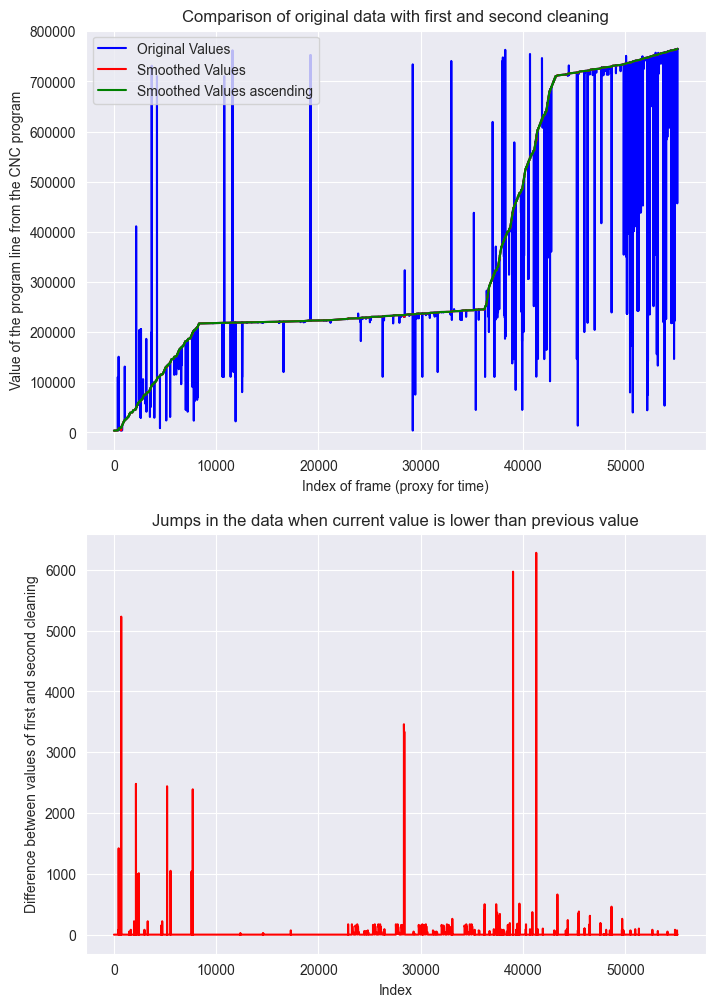

In [27]:
import numpy as np
import matplotlib.pyplot  as plt

x=np.arange(len(myIndicesPd))

plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plt.plot(x, myIndicesPd, label="Original Values", color='blue')
plt.plot(x, myCleanedIndices, label="Smoothed Values", color='red')
plt.plot(x, myAscendingCleanedData, label="Smoothed Values ascending", color='green')
plt.title("Comparison of original data with first and second cleaning")
plt.xlabel('Index of frame (proxy for time)')
plt.ylabel('Value of the program line from the CNC program')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(x, myAscendingCleanedData-myCleanedIndices, label="Smoothed Values", color='red')
plt.title("Jumps in the data when current value is lower than previous value")
plt.xlabel('Index')
plt.ylabel('Difference between values of first and second cleaning')
plt.show()

del x

In [31]:
myCompDf=pd.DataFrame({'Original': myIndicesPd, 'Cleaned': myCleanedIndices, 'Ascending': myAscendingCleanedData, "diff_cleaned": myAscendingCleanedData-myCleanedIndices})

del myIndicesPd, myCleanedIndices, myAscendingCleanedData

In [33]:
myCondensedDf=myCompDf[myCompDf['diff_cleaned']>500]
len(myCondensedDf)

102

## Data Are Cleaned
Data of the labels are now clean and stored in myCompDf (Columnn: Ascending)
Now we will update the labels in the DfLabelledTimeSeries dataframe
In order to ensure the labels are as expected, we will match the data from the provided program sequence (.txt file)


In [99]:
#Get the lines from the program
cncLines=[]
filepath="F:/Data_BachelorHES/Video_CNC/programmeCNC_Trimmed.txt"
with open(filepath, "r", encoding="utf-8") as f:
    cncLines = f.readlines()

cncLines=[line.strip() for line in cncLines]
del f, filepath  

In [100]:
def recognizeLineNumber(previousNum, differentLines, cncLine, i):
    try:
        myNum=int(cncLine.split(' ')[0].split('N')[-1])
    except ValueError:
        myNum=previousNum+5
        differentLines.append(i)
    return myNum, differentLines
    

progLines=[]
noIdxLines=[]
myPrevNum=int(cncLines[0].split(' ')[0].split('N')[-1])
myOp=(3335,"(PRE-PERCAGE D4.2)")

for i, line in enumerate(cncLines):
    myNum, noIdxLines = recognizeLineNumber(myPrevNum, noIdxLines, line, i)

    if myNum%10==0:
        progLines.append((myNum, line, myOp[0], myOp[1]))
        myPrevNum=myNum
    else:
        myOp=(myNum, line)
        myPrevNum=myNum-5
    

del i, line, myNum, myPrevNum, myOp, noIdxLines

In [102]:
myTools=["T07 M06 (MECHE MD D4.2)"]
for i, line in enumerate(progLines):
    secondStr=line[1].split(' ')[1:]
    ' '.join(i for i in secondStr)
    if 'T' in secondStr[0] and len(secondStr)>1:
        print(' '.join(i for i in secondStr))
        myTools.append(' '.join(i for i in secondStr))
    
del i, line, secondStr

T02 M06 (VHM 309-12)
T14 M06 (MECHE5.3)
T08 M06 (MECHE3.7 MD)
T09 M06 (MECHE4.6 MD)
T19 M06 (MECHE MD D4.8)
T10 M06 (MECHE5.5 MD)
T05 M06 (MECHE MD D5.8)
T24 M06 (FRSURF50X5)
T02 M06 (VHM 309-12)
T03 M06 (VHM 309-6)
T06 M06 (VHM 309-3)
T23 M06 (CHANF8)
T22 M06 (CHANF3)


In [103]:
myProgOpTool=[]
toolNb=0
for i, line in enumerate(progLines):
    if i==0:
        myProgOpTool.append([line[0], line[1], line[2], line[3], myTools[0]])
        toolNb+=1
    else:
        secondStr=line[1].split(' ')[1:]
        myStr=' '.join(i for i in secondStr)
        if toolNb<len(myTools):
            if myStr == myTools[toolNb] :
                toolNb+=1    
        myProgOpTool.append([line[0], line[1], line[2], line[3], myTools[toolNb-1]])
del toolNb, i, line, myStr, secondStr  

In [105]:
del cncLines, myTools, progLines

In [106]:
myCncProgDf=pd.DataFrame(myProgOpTool, columns=['Op_nb', 'Op_Name', 'BigOp_Nb', 'BigOp_Name', 'Tool_Name'])
myCncProgDf.drop(columns='BigOp_Nb', inplace=True)

In [107]:
del myProgOpTool

Now we have myCncProgDf that contains the program sequence with the operation number, the operation name and the tool name.

In [110]:
# Liste pour stocker les lignes correspondant à chaque Ascending
def newSequence(newSequenceDf, sequenceFromcsv):
    selected_rows = []

    for op_nb in newSequenceDf['Ascending']:
        # Filtrer les lignes correspondantes dans myCncProgDf
        matches = sequenceFromcsv[sequenceFromcsv['Op_nb'] == op_nb]
        # Ajouter les lignes correspondantes à la liste
        selected_rows.append(matches)
    return selected_rows
    
# Concaténer toutes les lignes sélectionnées en un nouveau DataFrame
newOpSeq = pd.concat(newSequence(myCompDf, myCncProgDf)).reset_index(drop=True)


In [113]:
DfLabelledTimeSeries['Label_Program_Line']=newOpSeq['Op_Name'].values
DfLabelledTimeSeries['Label_Op_Name']=newOpSeq['BigOp_Name'].values
DfLabelledTimeSeries['Label_Tool_Name']=newOpSeq['Tool_Name'].values
DfLabelledTimeSeries['Op_Nb'] = newOpSeq['Op_nb'].values

In [114]:
#Reorganisaton des colonnes pour avoir le numéro d'opération avant le nom de l'opération
cols = DfLabelledTimeSeries.columns.tolist()
idx = cols.index('Label_Program_Line')
new_cols = cols[:idx] + ['Op_Nb'] + cols[idx:-1]
DfLabelledTimeSeries = DfLabelledTimeSeries[new_cols]

In [115]:
import pyarrow as pa 
import pyarrow.parquet as pq

myResTable=pa.Table.from_pandas(DfLabelledTimeSeries)
pq.write_table(myResTable, 'F:/Data_BachelorHES/DataSet_CNC/CNC_Labelled_Data_Cleaned.parquet')
del myResTable

DfLabelledTimeseries now contains the corrected labels according to the cleanse of the outliers performed before.

## Data are ready to be studied

In [1]:
#Loading of the dataset for the study
import pandas as pd
import pyarrow as pa 

DfLabelledTimeSeriesCleaned=pd.read_parquet('F:/Data_BachelorHES/DataSet_CNC/CNC_Labelled_Data_Cleaned.parquet', engine='pyarrow')

In [34]:
DfLabelledTimeSeriesCleaned.describe()

,frame,frame_time_ms,frame_duration_ms,Data_points,Op_Nb
count,55117.000000,5.511700e+04,55117.000000,55117.000000,55117.000000
mean,147755.000000,4.926291e+06,166.702248,8335.112397,351041.149010
std,79555.258652,2.652447e+06,0.710134,35.506719,231852.309527
min,9965.000000,3.322456e+05,33.340000,1667.000000,3380.000000
25%,78860.000000,2.629278e+06,166.700000,8335.000000,219610.000000
50%,147755.000000,4.926276e+06,166.700000,8335.000000,233600.000000
75%,216650.000000,7.223308e+06,166.720000,8336.000000,593130.000000
max,285545.000000,9.520340e+06,200.040000,10002.000000,765000.000000


In [42]:
progLineCount=DfLabelledTimeSeries['Label_Program_Line'].value_counts()
opNameCount=DfLabelledTimeSeries['Label_Op_Name'].value_counts()
toolNameCount=DfLabelledTimeSeries['Label_Tool_Name'].value_counts()
print(f'Number of program lines represented: {len(progLineCount)}, on : {np.sum(progLineCount)} observations \n10 biggest program lines : \n {progLineCount[:10]}')

Number of program lines represented: 9937, on : 55117 observations 
10 biggest program lines : 
 Label_Program_Line
N230500 X-158.021 Y25.5 I-13.005 J0    289
N227090 X53.969 Y-25.5 I13.005 J0      288
N217250 G90 M01                        225
N236920 X158.021 Y-25.5 I13.005 J0     224
N230300 X-53.969 Y25.5 I-13.005 J0     223
N227380 X158.021 Y-25.5 I13.005 J0     222
N240130 X158.021 Y-25.5 I13.005 J0     222
N230590 X-158.021 Y25.5 I-13.005 J0    222
N227290 X158.021 Y-25.5 I13.005 J0     222
N230390 X-53.969 Y25.5 I-13.005 J0     222
Name: count, dtype: int64


In [43]:
print(f'Number of operations represented: {len(opNameCount)}, on : {np.sum(opNameCount)} observations \n10 first Operations  : \n {opNameCount[:10]}')

Number of operations represented: 114, on : 55117 observations 
10 first Operations  : 
 Label_Op_Name
(FIN 26H7)                 6250
(FIN 25H8)                 4269
(FIN CHAMBRAGE D10)        2487
(EB + FIN RAINURE R2 B)    2427
(EB + FIN RAINURE R2 A)    2405
(PERCAGE M4 A)             2249
(PERCAGE M6)               1730
(PERCAGE M4 B)             1706
(EB CHAMBRAGE D10)         1616
(PERCAGE M4 E)             1566
Name: count, dtype: int64


In [44]:
print(f'Number of tools represented: {len(toolNameCount)}, on : {np.sum(toolNameCount)} observations \n10 biggest program lines : \n {toolNameCount[:10]}')

Number of tools represented: 13, on : 55117 observations 
10 biggest program lines : 
 Label_Tool_Name
T02 M06 (VHM 309-12)       21997
T03 M06 (VHM 309-6)         7139
T08 M06 (MECHE3.7 MD)       6692
T06 M06 (VHM 309-3)         6509
T23 M06 (CHANF8)            5165
T09 M06 (MECHE4.6 MD)       1977
T10 M06 (MECHE5.5 MD)       1717
T24 M06 (FRSURF50X5)        1367
T14 M06 (MECHE5.3)          1323
T19 M06 (MECHE MD D4.8)      492
Name: count, dtype: int64


In [53]:
for idx_num, (idx_text, valeur) in enumerate(progLineCount.items()):
    if valeur<30:
        print(idx_num, idx_text, valeur)
        break

314 N223700 G98 G83 Z-17.056 R2. Q2. F1670. 29


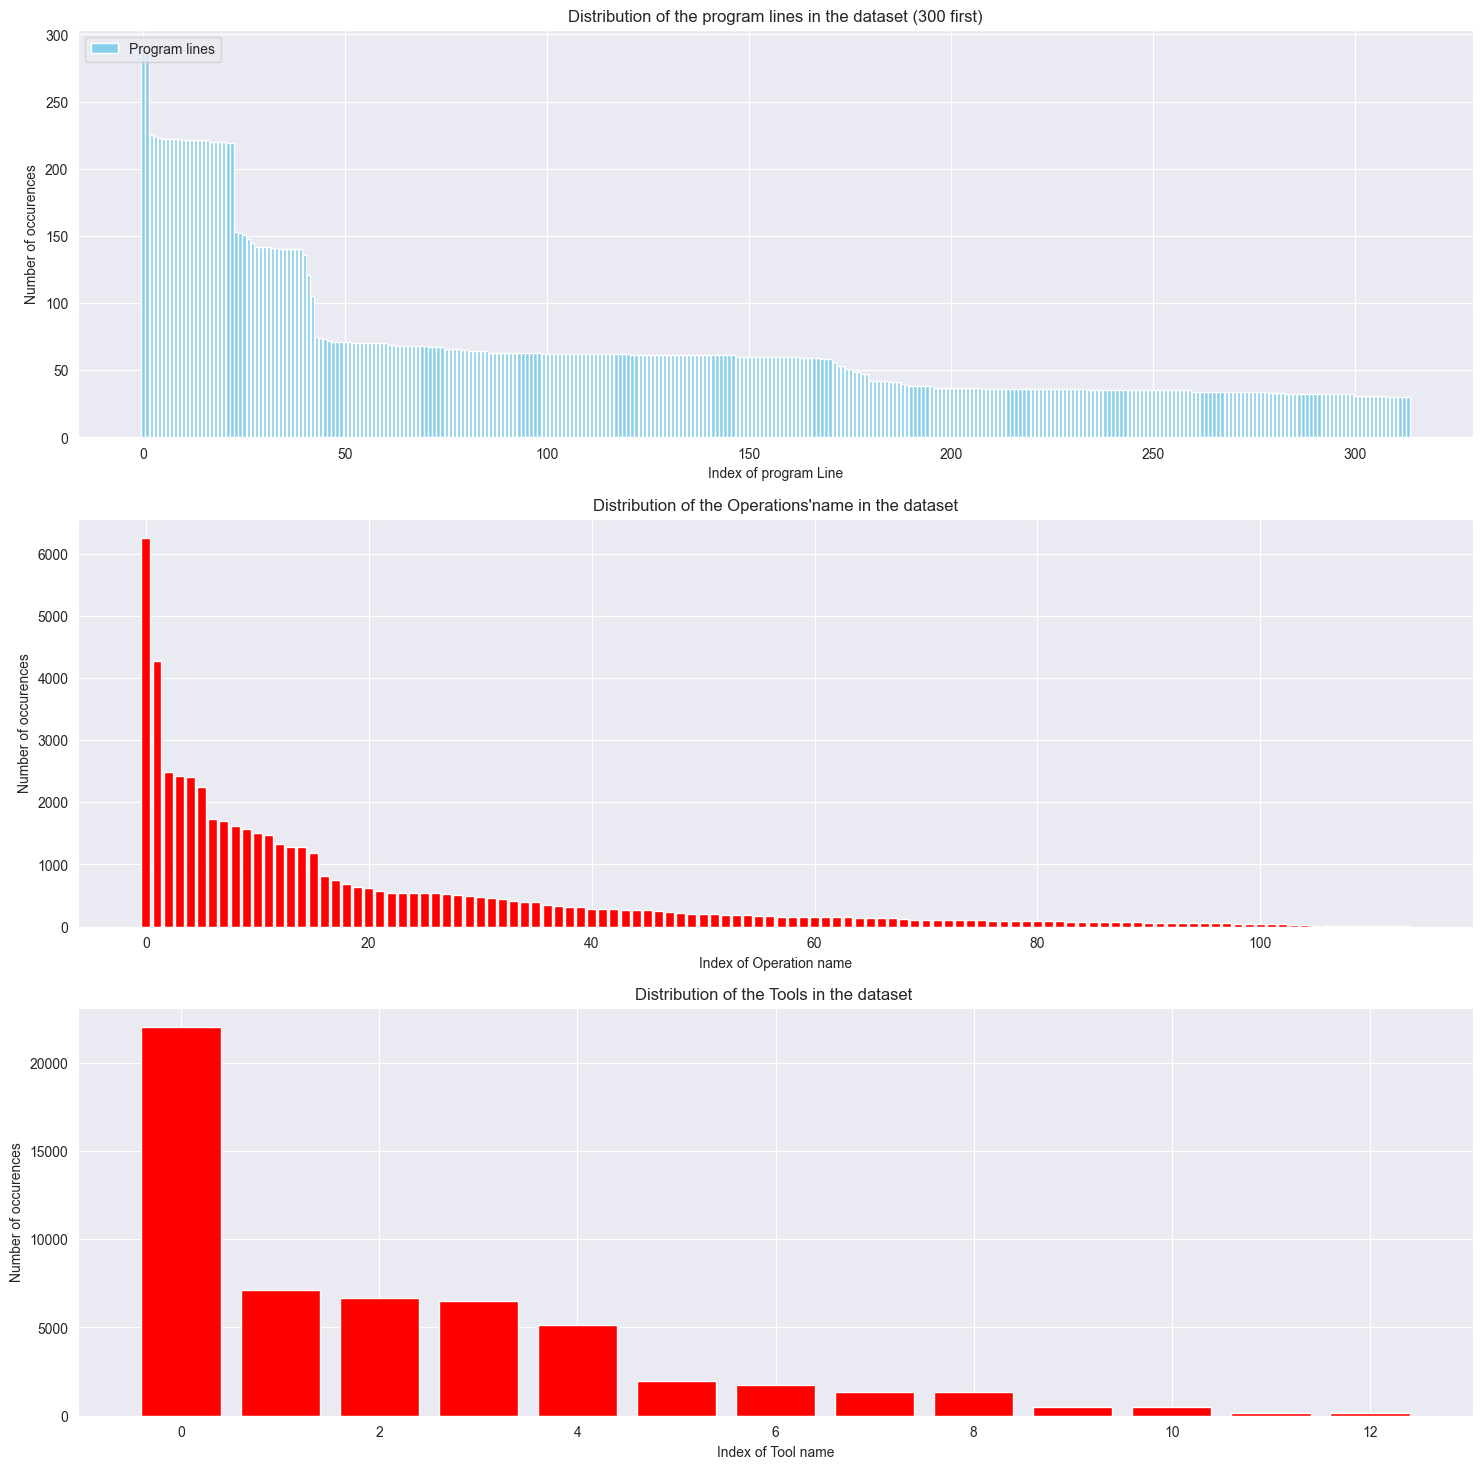

In [59]:

plt.figure(figsize=(18,18))
plt.subplot(3,1,1)
x=np.arange(len(progLineCount[:314]))
plt.bar(x, progLineCount[:314], label="Program lines", color="skyblue", edgecolor=None)
plt.title("Distribution of the program lines in the dataset (300 first)")
plt.xlabel('Index of program Line')
plt.ylabel('Number of occurences')
plt.legend(loc='upper left')

plt.subplot(3,1,2)
x=np.arange(len(opNameCount))
plt.bar(x, opNameCount, label="Smoothed Values", color='red')
plt.title("Distribution of the Operations'name in the dataset")
plt.xlabel('Index of Operation name')
plt.ylabel('Number of occurences')

plt.subplot(3,1,3)
x=np.arange(len(toolNameCount))
plt.bar(x, toolNameCount, label="Smoothed Values", color='red')
plt.title("Distribution of the Tools in the dataset ")
plt.xlabel('Index of Tool name')
plt.ylabel('Number of occurences')
plt.show()



del x

## Distribution of the labels
Tools : During the measurements 13 tools were used. We can see that tool T02 is the most used tool in the dataset. We will then have a "bias" toward that tool.
Operations : The dataset contains 114 different operations. The most used operation is "FIN 26H7".
Program lines : The dataset contains 9937 different program lines (Classes). The most used program line is "N230500 X-158.021 Y25.5 I-13.005 J0".
We can tell that labels of the dataet have an imbalanced distribution. At first, to avoid overfitting of the data, we will take the labels of the tools as the target variable. ProgLine and Operation name will be left aside for the moment.

We now need to prepare the data for the study. We will first split the data into training and testing sets. We will then investigate the distribution of the labels in the training set. In order to split the data, we will investigate the following techniques:
    - Visualize the temporal distribution of the labels
    - Cross-Validation with temporal blocs with each class represented in each fold
    - Stratified Cross-Validation on time series
    

Since labels of the dataset are imbalanced, we will investigate the following techniques on the training set :
SMOTE-Tomek, Undersampling, Data augmentation



In [60]:
DfLabelledTimeSeriesCleaned['frame_time_ms'] = DfLabelledTimeSeriesCleaned['frame_time_ms']-DfLabelledTimeSeriesCleaned['frame_time_ms'][0]

In [62]:
print(np.sum(DfLabelledTimeSeriesCleaned['Data_points'][:-1])/50000.0)

9188.09446


In [3]:
import matplotlib.pyplot as plt

# Tracer la répartition des classes dans le temps
 # Ajout d'un index temporel si non présent
def rep_classes_Time(labelledTimeSeries, labelName, showLegend=True, obsCount=None):
    if obsCount is not None:
        labelledTimeSeries=labelledTimeSeries[:obsCount]
        
    plt.figure(figsize=(12, 6))
    for label in labelledTimeSeries[labelName].unique():
        classData = labelledTimeSeries[labelledTimeSeries[labelName] == label]
        plt.plot(classData['frame_time_ms']/1000, [label] * len(classData), '.', label=f"Class {label}")
    if showLegend:
        plt.legend(loc="lower right")
    plt.title(f"Repartion of classes {labelName} over time")
    plt.xlabel("Time [s]")
    plt.ylabel("Class")
    plt.show()
    return classData
 

 


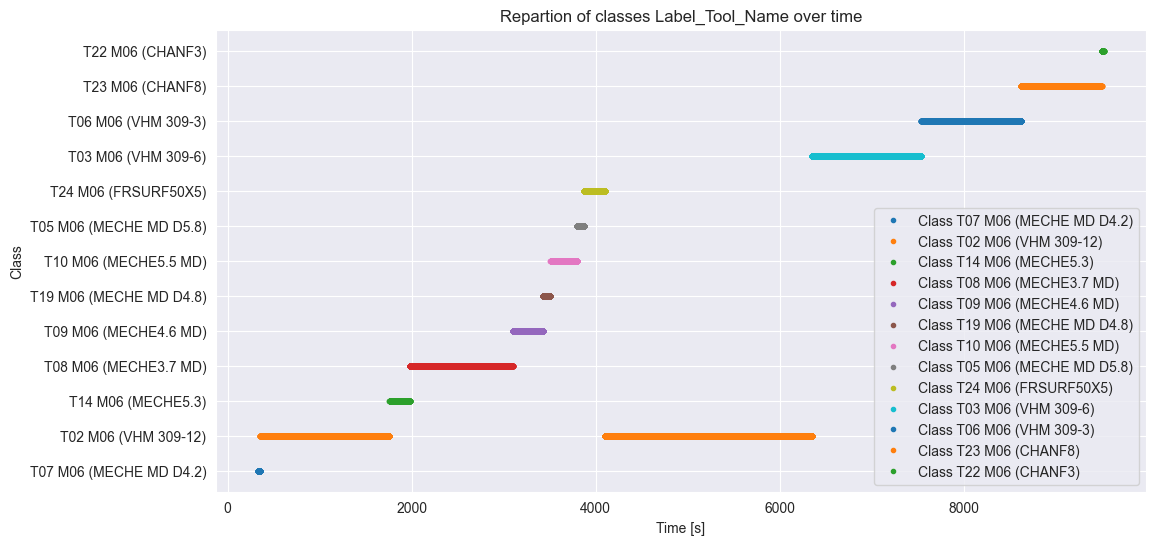

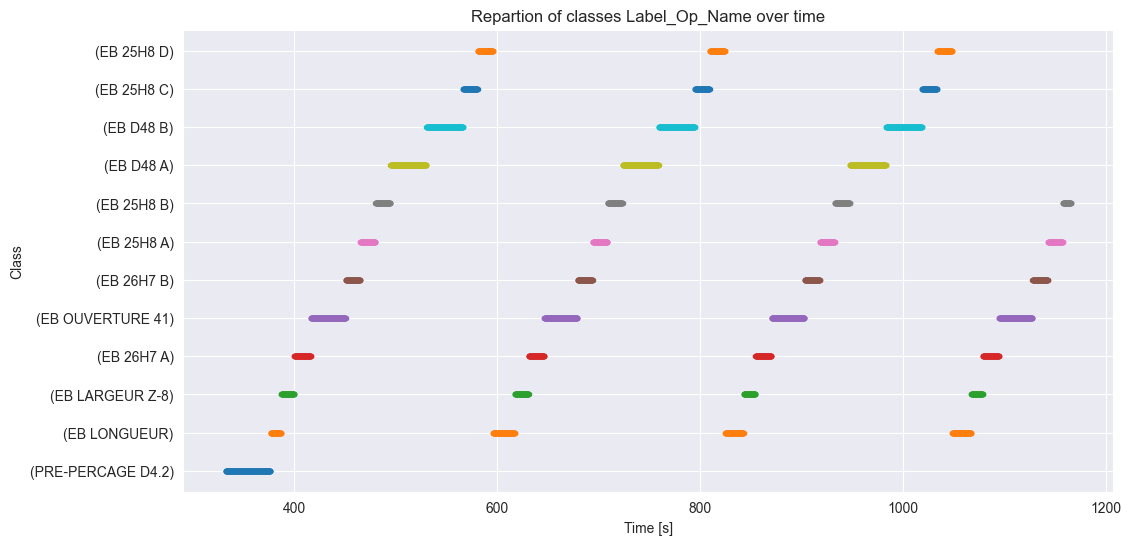

In [4]:
toolsRepart=rep_classes_Time(DfLabelledTimeSeriesCleaned, 'Label_Tool_Name')
operationsRepart=rep_classes_Time(DfLabelledTimeSeriesCleaned, 'Label_Op_Name', obsCount=5000, showLegend=False)
del toolsRepart, operationsRepart

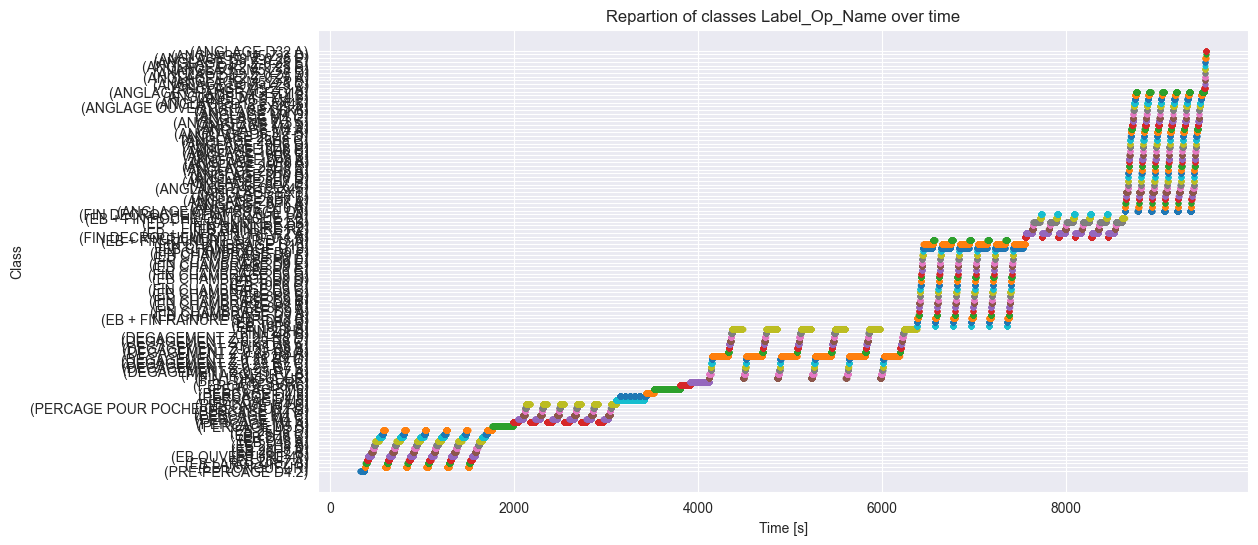

In [5]:
operationsRepart=rep_classes_Time(DfLabelledTimeSeriesCleaned, 'Label_Op_Name', showLegend=False)

del operationsRepart

Based on the repartition of classes over time we will adopt one of the two following strategies:
   - Cross-Validation with temporal blocs with each class represented in each fold: take blocs of time and split them into train and test sets wit first samples as train and last samples as test. Temporality is kept but classes can be imbalanced in each fold.

    - Stratified Cross-Validation on time series: For each class and time separate a portion for train and a portion for test (80/20). Temporality is not kept, classes are balanced in each fold.
    
Before going to the train / test separtion, we will investigate in more details the measurements of : sound, acceleration X, Y and Z. 

## Feature extraction

In [1]:
# Fonction pour extraire des caractéristiques d'une sous-fenêtre

from scipy.stats import skew, kurtosis
from scipy.fft import fft
import numpy as np

def extractFeaturesFromFrame(measLst,label=""):
    fs=50000
    fftCoeffs = np.abs(fft(measLst))
    freq= np.fft.fftfreq(len(measLst), d=1/fs)
    maxIdx = np.argmax(fftCoeffs[freq>=0])
    max_amplitude = fftCoeffs[maxIdx]
    dominant_frequency = freq[maxIdx]
    return {
        f'mean_{label}': np.mean(measLst),
        f'std_{label}': np.std(measLst),
        f'min_{label}': np.min(measLst),
        f'max_{label}': np.max(measLst),
        f'energy_{label}': np.sum(np.square(measLst)),
        f'rootMeanSquare_{label}': np.sqrt(np.mean(np.square(measLst))),
        f'skewness_{label}': skew(measLst),
        f'kurtosis_{label}': kurtosis(measLst),
        f'fft_peak_amplitude_{label}': max_amplitude,
        f'fft_peak_frequency_{label}': dominant_frequency
    }

sound='Sound'
accX='Accel X'
accY='Accel Y'
accZ='Accel Z'

In [2]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa 

DfLabelledTimeSeries=pd.read_parquet('F:/Data_BachelorHES/DataSet_CNC/CNC_Labelled_Data_Cleaned.parquet', engine='pyarrow')

In [34]:
mySndFeatures=DfLabelledTimeSeriesCleaned[sound].apply(lambda x: pd.Series(extractFeaturesFromFrame(x)))

In [35]:
myAccXFeatures=DfLabelledTimeSeriesCleaned[accX].apply(lambda x: pd.Series(extractFeaturesFromFrame(x)))

In [36]:
myAccYFeatures=DfLabelledTimeSeriesCleaned[accY].apply(lambda x: pd.Series(extractFeaturesFromFrame(x)))

In [37]:
myAccZFeatures=DfLabelledTimeSeriesCleaned[accZ].apply(lambda x: pd.Series(extractFeaturesFromFrame(x)))

In [52]:
# Ajouter un suffixe aux colonnes de chaque DataFrame
mySndFeatures = mySndFeatures.add_suffix('_Snd')
myAccXFeatures = myAccXFeatures.add_suffix('_AccX')
myAccYFeatures = myAccYFeatures.add_suffix('_AccY')
myAccZFeatures = myAccZFeatures.add_suffix('_AccZ')

In [41]:
TimeStamps=[]

In [45]:
from itertools import accumulate

TimeStamps=[DfLabelledTimeSeriesCleaned['Data_points'][i-1]/50 for i in range(1, len(DfLabelledTimeSeriesCleaned['Data_points']))]
TimeStamps.insert(0,0)

TimeStamps = list(accumulate(TimeStamps))


In [48]:
TimeStamps=pd.Series(TimeStamps)

In [56]:
myDefinitiveDf=pd.concat([TimeStamps, DfLabelledTimeSeriesCleaned['Sound'],DfLabelledTimeSeriesCleaned['Accel X'],DfLabelledTimeSeriesCleaned['Accel Y'], DfLabelledTimeSeriesCleaned['Accel Z'], mySndFeatures, myAccXFeatures, myAccYFeatures, myAccZFeatures, DfLabelledTimeSeriesCleaned['Label_Tool_Name']], axis=1)

In [67]:
del mySndFeatures, myAccXFeatures, myAccYFeatures, myAccZFeatures, fft ,TimeStamps

In [ ]:
myDefinitiveDf.rename(columns={0:'Time'}, inplace=True)

In [89]:
import pyarrow as pa 
import pyarrow.parquet as pq

myResTable=pa.Table.from_pandas(myDefinitiveDf)
pq.write_table(myResTable, 'F:/Data_BachelorHES/DataSet_CNC/Labels_Data_Statistics.parquet')
del myResTable

In [87]:

def compute_statistics(labelledTimeSeries, col, label):
    grouped = labelledTimeSeries.groupby(label).agg({
        col: lambda x: np.concatenate(x.values)
    })
    return grouped
test=pd.concat([compute_statistics(myDefinitiveDf, col='Sound', label='Label_Tool_Name'), compute_statistics(myDefinitiveDf, col='Accel X', label='Label_Tool_Name')['Accel X'], compute_statistics(myDefinitiveDf, col='Accel Y', label='Label_Tool_Name')['Accel Y'], compute_statistics(myDefinitiveDf, col='Accel Z', label='Label_Tool_Name')['Accel Z']], axis=1)


len(test.iloc[1,-1])


59462967

In [ ]:
myByLabelTable=pa.Table.from_pandas(test)

In [91]:
pq.write_table(myByLabelTable, 'F:/Data_BachelorHES/DataSet_CNC/Data_GroupedByLabels.parquet')
del myByLabelTable

In [3]:
pip install dask


   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 8.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\Julie\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [5]:
import pyarrow as pa 
import pyarrow.parquet as pq
import pandas as pd
import dask.dataframe as dd
DfFrameStatistics=dd.read_parquet('F:/Data_BachelorHES/DataSet_CNC/Labels_Data_Statistics.parquet', engine='pyarrow')

In [9]:
rows=[]
firstRow=DfFrameStatistics.head(1).iloc[0]
dictLabels={'start':firstRow['Time'], 'end':0, 'label':firstRow['Label_Tool_Name'], 'sound':list(firstRow['Sound']), 'Accel X':list(firstRow['Accel X']), 'Accel Y':list(firstRow['Accel Y']), 'Accel Z':list(firstRow['Accel Z'])}

print(f"start: {dictLabels['start']},  Label: {dictLabels['label']}, sound:  {len(dictLabels['sound'])}, accel X:  {len(dictLabels['Accel X'])}, accel Y:  {len(dictLabels['Accel Y'])}, accel Z:  {len(dictLabels['Accel Z'])}")

firstChunk=True
# Transformer Dask en Pandas par morceaux (chunk processing)
for chunk in DfFrameStatistics.to_delayed():  
    
    pdf = chunk.compute()  # Convertir le chunk en DataFrame Pandas
    if pdf.empty:
        continue  # Ignorer les chunks vides

    startIdx = 1 if firstChunk else 0
    
    firstChunk = False
    
    for i in range(startIdx, len(pdf)):  # Boucler sur les lignes du chunk
        actualRow = pdf.iloc[i]
     
     
        if actualRow['Label_Tool_Name']==dictLabels['label']:
            dictLabels['sound'].extend(actualRow['Sound'])
            dictLabels['Accel X'].extend(actualRow['Accel X'])
            dictLabels['Accel Y'].extend(actualRow['Accel Y'])
            dictLabels['Accel Z'].extend(actualRow['Accel Z'])
        else:
            dictLabels['end']=actualRow['Time']
            print(f"start: {dictLabels['start']}, end: {dictLabels['end']}, Label: {dictLabels['label']}, sound:  {len(dictLabels['sound'])}, accel X:  {len(dictLabels['Accel X'])}, accel Y:  {len(dictLabels['Accel Y'])}, accel Z:  {len(dictLabels['Accel Z'])}")
            filteredDict = {key: dictLabels[key] for key in ['start', 'end', 'label']}
            rows.append({**filteredDict,**extractFeaturesFromFrame(dictLabels['sound'],"Sound"), **extractFeaturesFromFrame(dictLabels['Accel X'],"Accel X"), **extractFeaturesFromFrame(dictLabels['Accel Y'],'Accel Y'), **extractFeaturesFromFrame(dictLabels['Accel Z'],'Accel Z')})
            
            dictLabels={'start':actualRow['Time'], 'end':0, 'label':actualRow['Label_Tool_Name'], 'sound':list(actualRow['Sound']), 'Accel X':list(actualRow['Accel X']), 'Accel Y':list(actualRow['Accel Y']), 'Accel Z':list(actualRow['Accel Z'])}
            
# Ajouter la dernière ligne
if not pdf.empty:
    dictLabels['end'] = pdf.iloc[-1]['Time']
    filteredDict = {key: dictLabels[key] for key in ['start', 'end', 'label']}
    rows.append({**filteredDict,**extractFeaturesFromFrame(dictLabels['sound'],"Sound"), **extractFeaturesFromFrame(dictLabels['Accel X'],"Accel X"), **extractFeaturesFromFrame(dictLabels['Accel Y'],'Accel Y'), **extractFeaturesFromFrame(dictLabels['Accel Z'],'Accel Z')})
DfLabelsStats=pd.DataFrame(rows)  
del rows, firstRow, actualRow, dictLabels,i

start: 0.0,  Label: T07 M06 (MECHE MD D4.2), sound:  8335, accel X:  8335, accel Y:  8335, accel Z:  8335
start: 0.0, end: 23172.360000000044, Label: T07 M06 (MECHE MD D4.2), sound:  1158618, accel X:  1158618, accel Y:  1158618, accel Z:  1158618
start: 23172.360000000044, end: 1426984.499999786, Label: T02 M06 (VHM 309-12), sound:  70190607, accel X:  70190607, accel Y:  70190607, accel Z:  70190607
start: 1426984.499999786, end: 1647205.359999734, Label: T14 M06 (MECHE5.3), sound:  11011043, accel X:  11011043, accel Y:  11011043, accel Z:  11011043
start: 1647205.359999734, end: 2765780.640000403, Label: T08 M06 (MECHE3.7 MD), sound:  55928764, accel X:  55928764, accel Y:  55928764, accel Z:  55928764
start: 2765780.640000403, end: 3095695.1600007857, Label: T09 M06 (MECHE4.6 MD), sound:  16495726, accel X:  16495726, accel Y:  16495726, accel Z:  16495726
start: 3095695.1600007857, end: 3176548.4000008795, Label: T19 M06 (MECHE MD D4.8), sound:  4042662, accel X:  4042662, accel 

In [11]:
import pyarrow as pa 
import pyarrow.parquet as pq

myResTable=pa.Table.from_pandas(DfLabelsStats)
pq.write_table(myResTable, 'F:/Data_BachelorHES/DataSet_CNC/StatsByLabel_Time.parquet')
del myResTable

In [32]:
# 📌 Fonction pour récupérer la durée d'un fichier (audio ou vidéo)
def get_file_duration(file_path, fs):
    try:
        ext = os.path.splitext(file_path)[1]

        # For .csv files
        if ext in [".csv"]:
           with open(file_path, 'r', newline='', encoding="utf-8") as csvfile:
            raw_data = csvfile.read().replace("\r\n", "")  # Supprimer les retours à la ligne
            myReader= list(csv.reader([raw_data], delimiter=','))
            return  float(len(myReader[0])/fs) #Duration in seconds

        # Other types of files
        else:
            return None  # Pas de durée disponible

    except Exception as e:
        print(f"Error with : {file_path}: {e}")
        return None

In [71]:
import os
import csv
from pathlib import Path
import pandas as pd

# 📌 Dossier à scanner (modifie ce chemin selon ton projet)
base_dir = "F:/Data_BachelorHES/DataSet_CNC/segments/"



# 📌 Scanner les fichiers du dossier et sous-dossiers
myDirs=[]
xs=[]
ys=[]
zs=[]
snds=[]
nbs=[]
labels=[]
durs=[]
j=1
fs=50000
lastnb=None
for root, dirs, files in os.walk(base_dir):
    for file in files:
        
        measName=file.split("_")[1]
        nb=int(file.split("_")[0])
        if nb != lastnb or lastnb == None:
            file_path = Path(root) / file
            myDir=str(file_path).split('segments')[-1].split("\\")[1]
            label=myDir.split('Label_')[-1]
            durs.append(get_file_duration(file_path, fs))
            labels.append(label)
            myDirs.append(myDir)
            nbs.append(nb)
            print(j, nb, file)
            j+=1
        if measName=='sound':
            snds.append(file)
        if measName=='accX':
            xs.append(file)
        if measName=='accY':
            ys.append(file)
        if measName=='accZ':
            zs.append(file)

        lastnb=nb

del lastnb, nb, j, root, myDir, measName, file, file_path, dirs, files, label

# 📌 Créer un DataFrame avec les informations
df = pd.DataFrame({'nb':nbs, 'dir':myDirs, 'label':labels, 'sound':snds, 'accelX':xs, 'accelY':ys, 'accelZ':zs, 'duration': durs})
del labels, nbs, myDirs, snds, xs, ys, zs, durs, fs


1 759 0759_accX_label_T02 M06 (VHM 309-12).csv
2 760 0760_accX_label_T02 M06 (VHM 309-12).csv
3 761 0761_accX_label_T02 M06 (VHM 309-12).csv
4 762 0762_accX_label_T02 M06 (VHM 309-12).csv
5 763 0763_accX_label_T02 M06 (VHM 309-12).csv
6 764 0764_accX_label_T02 M06 (VHM 309-12).csv
7 765 0765_accX_label_T02 M06 (VHM 309-12).csv
8 766 0766_accX_label_T02 M06 (VHM 309-12).csv
9 767 0767_accX_label_T02 M06 (VHM 309-12).csv
10 768 0768_accX_label_T02 M06 (VHM 309-12).csv
11 769 0769_accX_label_T02 M06 (VHM 309-12).csv
12 770 0770_accX_label_T02 M06 (VHM 309-12).csv
13 771 0771_accX_label_T02 M06 (VHM 309-12).csv
14 772 0772_accX_label_T02 M06 (VHM 309-12).csv
15 773 0773_accX_label_T02 M06 (VHM 309-12).csv
16 774 0774_accX_label_T02 M06 (VHM 309-12).csv
17 775 0775_accX_label_T02 M06 (VHM 309-12).csv
18 776 0776_accX_label_T02 M06 (VHM 309-12).csv
19 777 0777_accX_label_T02 M06 (VHM 309-12).csv
20 778 0778_accX_label_T02 M06 (VHM 309-12).csv
21 779 0779_accX_label_T02 M06 (VHM 309-12).csv
2

In [72]:
df.sort_values(by='nb', inplace=True)
df["nb"]=df["nb"]-1

In [73]:
df=df.set_index("nb", drop=False)

In [74]:
label_counts=df['label'].value_counts()

In [75]:
VHM309=0
CHANF=0
MECHE=0
FRSURF=0
MECHEMD=0

for index, row in label_counts.items():
    if 'VHM' in index:
        VHM309+=row
    if 'CHANF' in index:
        CHANF+=row
    if ('MECHE' in index) and ('MD'in index):
        MECHEMD+=row
    if ('MECHE' in index) and (not 'MD' in index):
        MECHE+=row
    if ('FRSURF' in index):
        FRSURF+=row
    

In [76]:
condensedLabelLst=[]
for row in df.iterrows():
    if 'VHM' in row[1]['label']:
        condensedLabelLst.append('VHM')
    if 'CHANF' in row[1]['label']:
        condensedLabelLst.append('CHANF')
    if ('MECHE' in row[1]['label']) and ('MD'in row[1]['label']):
        condensedLabelLst.append('MECHMD')
    if ('MECHE' in row[1]['label']) and (not 'MD' in row[1]['label']):
        condensedLabelLst.append('MECHE')
    if ('FRSURF' in row[1]['label']):
        condensedLabelLst.append('FRSURF')
df=pd.concat([df, pd.DataFrame({'condensedLabel':condensedLabelLst})], axis=1)

1_T07 M06 (MECHE MD D4.2)
1_T07 M06 (MECHE MD D4.2)
1_T07 M06 (MECHE MD D4.2)
1_T07 M06 (MECHE MD D4.2)
1_T07 M06 (MECHE MD D4.2)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-12)
2_T02 M06 (VHM 309-

In [ ]:
from sklearn.model_selection import train_test_split

# Séparer en train (80%) et test (20%) en gardant la distribution des labels
df_train, df_test = train_test_split(df_files, test_size=0.2, stratify=df_files["label"], random_state=42)


In [95]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
X=df[['sound', 'accelX', 'accelY', 'accelZ']]
Y=df['label']

trainSerie=pd.Series(np.nan, index=list(Y.unique()))
trainDf=pd.DataFrame(trainSerie , columns=['Init'])
testDf=pd.DataFrame(trainSerie , columns=['Init'])
del trainSerie

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
foldData=[]
for i, (train_index, test_index) in enumerate(sss.split(X,Y)):
    foldData.append((train_index, test_index))

    classTrain=Y[train_index].value_counts()
    classTrain=classTrain/len(train_index)
    trainDf[f"Fold {i}" ]=classTrain

    classTest=Y[test_index].value_counts()
    classTest=classTest/len(test_index)
    testDf[f"Fold {i}" ]=classTest

trainDf.drop(columns='Init', inplace=True)
testDf.drop(columns='Init', inplace=True)

Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


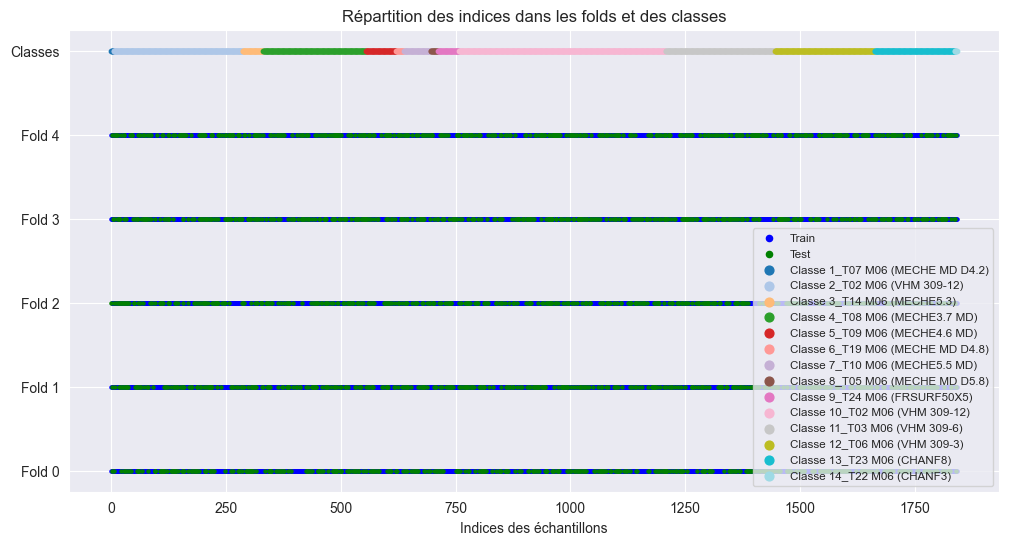

In [112]:
#Prepare a plot of distribution of data in each fold
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib as mpl

# Création de la figure
fig, ax = plt.subplots(figsize=(12, 6))
# Labels des classes
labels=Y.unique()
# Nombre de folds + 1 pour la barre des classes
nbFolds = len(foldData) + 1

# Création des barres pour chaque fold
for i, (train_index, test_index) in enumerate(foldData):
    y_train = np.full(len(train_index), i)  # Position des barres train
    y_test = np.full(len(test_index), i)  # Position des barres test
    ax.scatter(train_index, y_train, color="blue", s=5, label="Train" if i == 0 else "")
    ax.scatter(test_index, y_test, color="green", s=5, label="Test" if i == 0 else "")

# Ajout de la dernière barre pour la distribution des classes
y_classes = np.full(len(Y), nbFolds - 1)  # Dernière ligne pour les classes

# Attribution d'une couleur par classe
tab20 = mpl.colormaps['tab20'].resampled(len(labels))
class_colors = {label: tab20.colors[i] for i, label in enumerate(labels)}

for label in labels:
    indices = np.where(Y == label)[0]
    y_classes = np.full(len(indices), nbFolds - 1) 
    ax.scatter(indices, y_classes, color=class_colors[label], s=10, label=f"Classe {label}")

# Configuration de l'axe
ax.set_yticks(range(nbFolds))
ax.set_yticklabels([f"Fold {i}" for i in range(len(foldData))] + ["Classes"])
ax.set_xlabel("Indices des échantillons")
ax.set_title("Répartition des indices dans les folds et des classes")
ax.legend(loc="lower right", markerscale=2, fontsize="small")

# Afficher la visualisation
plt.show()
